In [5]:
import pandas as pd
from pathlib import Path
import ast
import re

def load_movie_remakes(path=Path("../data/MovieRemakes/movieRemakesManuallyCleaned.tsv")):
    """
    Load the movie remakes dataset from the TSV file.
    
    Returns:
    --------
    DataFrame with columns:
    - cluster_id: ID for the remake cluster
    - movies: List of dictionaries containing movie information (id, title, summary)
    """
    clusters = []
    
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
           
            parts = line.strip().split('\t', 2)
            if len(parts) == 3:
                index, cluster_id, movies_str = parts
    
                movies_str = movies_str.strip()
                movies = movies_str.split("\t")
                # [id, title, summary, id, title, summary, ...]
                for i in range(0, len(movies), 3):
                    movie = movies[i:i+3]
                    title, summary, title_id = None, None, None
                    match len(movie):
                        case 3:
                            title, summary, title_id = movie
                        case 2:
                            title, summary = movie
                        case _:
                            print(f"Warning: Could not parse line: {line[:100]}...")
                            continue
                    
                    clusters.append({
                        'cluster_id': cluster_id,
                        'title': title,
                        'summary': summary,
                        'title_id': title_id
                    })
    
    return pd.DataFrame(clusters)


df = load_movie_remakes()


print("First remake cluster:")
print(df.groupby('cluster_id').size().describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print(df.groupby('cluster_id').size().sort_values(ascending=False))
df.head()
    

First remake cluster:
count    266.000000
mean       2.169173
std        0.540395
min        2.000000
25%        2.000000
50%        2.000000
75%        2.000000
90%        3.000000
95%        3.000000
99%        4.000000
max        7.000000
dtype: float64
cluster_id
62084       7
19985118    4
1059238     4
24838328    4
21107874    4
           ..
1190931     2
11993205    2
12498208    2
1250208     2
998111      2
Length: 266, dtype: int64


,cluster_id,title,summary,title_id
0,14141235,12_(2007_film),The jury decides whether a young Chechen boy i...,11081144
1,14141235,12_Angry_Men_(1997_film),After the final closing arguments have been pr...,11094452
2,14141235,Ek_Ruka_Hua_Faisla,The story begins in a courtroom where a teenag...,92605
3,14141235,12_Angry_Men_(1957_film),The story begins in a courtroom where an 18-ye...,None
4,21798180,13_(2010_film),"Vincent ""Vince"" Ferro overhears people talkin...",4734122


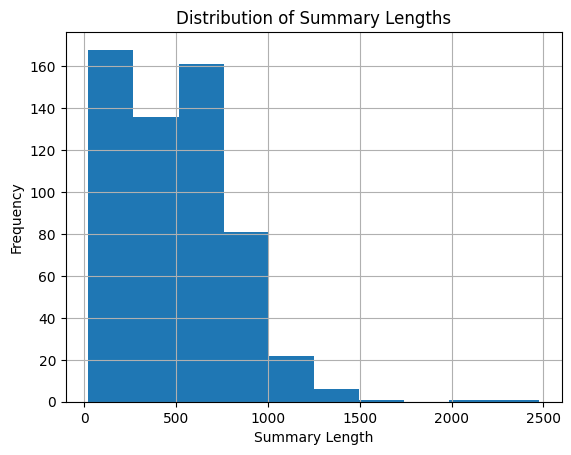

In [6]:
from matplotlib import pyplot as plt
import re
df["summary"] = df["summary"].apply(lambda x: re.sub(r'\s+', ' ', x))
df['summary_length'] = df['summary'].apply(lambda x: len(x.split(" ")))
df['summary_length'].describe()
# name axes
df['summary_length'].hist()
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.title('Distribution of Summary Lengths')
plt.show()

df = pd.read_csv("movie_remakes_with_queries.csv")



In [7]:
df["summary_length"].describe()


count     577.000000
mean      496.162912
std       318.557651
min        22.000000
25%       234.000000
50%       477.000000
75%       706.000000
max      2477.000000
Name: summary_length, dtype: float64

In [8]:
# from adalflow import Generator, OllamaClient, OpenAIClient
# from tqdm import tqdm
# model_name = "gpt-4o-mini"
# OPENAI_API_KEY = "xxx"
# model_client = OpenAIClient(api_key=OPENAI_API_KEY)
# model_kwargs = {"model": model_name}

# template = """<SYS>You are a helpful assistant that can reformulate movie summary to a query that can be used to find similar movies. Answer only with the query.</SYS>
# User: {{input_str}}
# You:"""

# generator = Generator(model_client=model_client,
#                        model_kwargs=model_kwargs,
#                        template=template)
# queries = []
# for summary in tqdm(df["summary"].tolist()):
#     queries.append(generator(prompt_kwargs={"input_str": "Write the best query to retrieve similar movies to this movie: "+summary}).raw_response)
# df["query"] = queries
# df.to_csv("movie_remakes_with_queries_gpt-4o-mini.csv", index=False)  
 


In [9]:
import os
import numpy as np
from FlagEmbedding import BGEM3FlagModel
df["query"] = df["query"].apply(lambda x: x.strip("\""))
if not os.path.exists("movie_remakes_embeddings.npy"):
    model = BGEM3FlagModel(model_name_or_path="BAAI/bge-m3")
    summary_embeddings = model.encode(df['summary'].tolist(), batch_size=64)["dense_vecs"]
    query_embeddings = model.encode(df['query'].tolist(), batch_size=64)["dense_vecs"]
    np.save("movie_remakes_embeddings.npy", summary_embeddings)
    np.save("movie_remakes_query_embeddings.npy", query_embeddings)
    np.save("movie_remakes_cluster_ids.npy", df['cluster_id'].tolist())
else:
    summary_embeddings = np.load("movie_remakes_embeddings.npy")
    query_embeddings = np.load("movie_remakes_query_embeddings.npy")





In [10]:
summary_embeddings.shape
query_embeddings.shape


(577, 1024)

: 

In [11]:
from umap import UMAP
import pacmap

umap_embeddings = UMAP(n_components=10, metric="euclidean").fit_transform(summary_embeddings)
pacmap_embeddings = pacmap.PaCMAP(n_components=10, distance="euclidean").fit_transform(summary_embeddings)
paramrepulsor = np.load("movie_remakes_embeddings_low.npy")


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
import hdbscan

clusterd_df = df.copy()

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
umap_cluster_labels = clusterer.fit_predict(umap_embeddings)
pacmap_cluster_labels = clusterer.fit_predict(pacmap_embeddings)

clusterd_df["hdbscan_umap_cluster_id"] = umap_cluster_labels
clusterd_df["hdbscan_pacmap_cluster_id"] = pacmap_cluster_labels


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
from sklearn.cluster import AgglomerativeClustering
aglo = AgglomerativeClustering(n_clusters=None, distance_threshold=0.34, metric="euclidean")
clusterd_df["agglomerative_umap_cluster_id"] = aglo.fit_predict(umap_embeddings)
clusterd_df["agglomerative_pacmap_cluster_id"] = aglo.fit_predict(pacmap_embeddings)


 


In [10]:
configs = ["hdbscan_umap", "hdbscan_pacmap", "agglomerative_umap", "agglomerative_pacmap"]

def evaluate_clusters(y_true, y_pred):
    from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                                 homogeneity_score, completeness_score, v_measure_score, 
                                 fowlkes_mallows_score)
    
 
    
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    homogeneity = homogeneity_score(y_true, y_pred)
    completeness = completeness_score(y_true, y_pred)
    v_measure = v_measure_score(y_true, y_pred)
    fmi = fowlkes_mallows_score(y_true, y_pred)
    
    results = {
        "Adjusted Rand Index": ari,
        "Normalized Mutual Information": nmi,
        "Homogeneity": homogeneity,
        "Completeness": completeness,
        "V-measure": v_measure,
        "Fowlkes-Mallows Index": fmi,
    }
    
    return results
results = []
for config in configs:
    print(f"Evaluating {config}")
    print(evaluate_clusters(clusterd_df["cluster_id"].tolist(), clusterd_df[f"{config}_cluster_id"].tolist()))
    





Evaluating hdbscan_umap
{'Adjusted Rand Index': 0.02671521543225081, 'Normalized Mutual Information': np.float64(0.714316224781398), 'Homogeneity': np.float64(0.5890636230476742), 'Completeness': np.float64(0.9072179918869278), 'V-measure': np.float64(0.714316224781398), 'Fowlkes-Mallows Index': np.float64(0.09716444468734495)}
Evaluating hdbscan_pacmap
{'Adjusted Rand Index': 0.0005136325098542485, 'Normalized Mutual Information': np.float64(0.07892479399737888), 'Homogeneity': np.float64(0.0411858367853006), 'Completeness': np.float64(0.9430511321434734), 'V-measure': np.float64(0.07892479399737887), 'Fowlkes-Mallows Index': np.float64(0.04958511311789072)}
Evaluating agglomerative_umap
{'Adjusted Rand Index': 0.4560986965430923, 'Normalized Mutual Information': np.float64(0.9316831505998927), 'Homogeneity': np.float64(0.9380034048443597), 'Completeness': np.float64(0.9254474978865431), 'V-measure': np.float64(0.9316831505998927), 'Fowlkes-Mallows Index': np.float64(0.457549207916394

In [11]:
print(len(clusterd_df["agglomerative_umap_cluster_id"].unique()))
print(len(clusterd_df["hdbscan_umap_cluster_id"].unique()))
clusterd_df[clusterd_df["hdbscan_umap_cluster_id"] == 50]


320
83


,cluster_id,title,summary,title_id,summary_length,query,hdbscan_umap_cluster_id,hdbscan_pacmap_cluster_id,agglomerative_umap_cluster_id,agglomerative_pacmap_cluster_id
71,998111,Bored_of_Education,"It is the first day of school, and the kids wa...",1682637.0,293,children's school comedy with mischievous sche...,50,1,291,312
164,19845179,Fame_(2009_film),During the opening scenes in auditions and or...,639629.0,1301,high school drama music performing arts coming...,50,1,119,440
165,19845179,Fame_(1980_film),We see the principal students auditioning alo...,NaN,795,Query: Movies that focus on high school perfor...,50,1,119,59
186,24570673,Footloose_(2011_film),"After a long night of partying, Bobby Moore an...",877743.0,659,"Similar movies to ""Footloose"" featuring themes...",50,1,35,59
187,24570673,Footloose_(1984_film),"Ren McCormack , a teenager raised in Chicago, ...",NaN,289,"teenage rebellion, small town restrictions, mu...",50,1,35,434
311,3477283,Can%27t_Buy_Me_Love_(film),Ronald Miller is a typical high school nerd li...,NaN,846,high school romantic comedy where a nerd pays ...,50,1,35,299


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

Done UMAP_HDBSCAN with n_components=2


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done UMAP_HDBSCAN with n_components=5


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done UMAP_HDBSCAN with n_components=10


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done UMAP_HDBSCAN with n_components=20


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done UMAP_HDBSCAN with n_components=200
Done UMAP_AgglomerativeClustering with n_components=2


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done UMAP_AgglomerativeClustering with n_components=5


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done UMAP_AgglomerativeClustering with n_components=10


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done UMAP_AgglomerativeClustering with n_components=20


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done UMAP_AgglomerativeClustering with n_components=200


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Done PaCMAP_HDBSCAN with n_components=2


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Done PaCMAP_HDBSCAN with n_components=5


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Done PaCMAP_HDBSCAN with n_components=10


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Done PaCMAP_HDBSCAN with n_components=20


c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Done PaCMAP_HDBSCAN with n_components=200


Done PaCMAP_AgglomerativeClustering with n_components=2


Done PaCMAP_AgglomerativeClustering with n_components=5


Done PaCMAP_AgglomerativeClustering with n_components=10


Done PaCMAP_AgglomerativeClustering with n_components=20
Done PaCMAP_AgglomerativeClustering with n_components=200


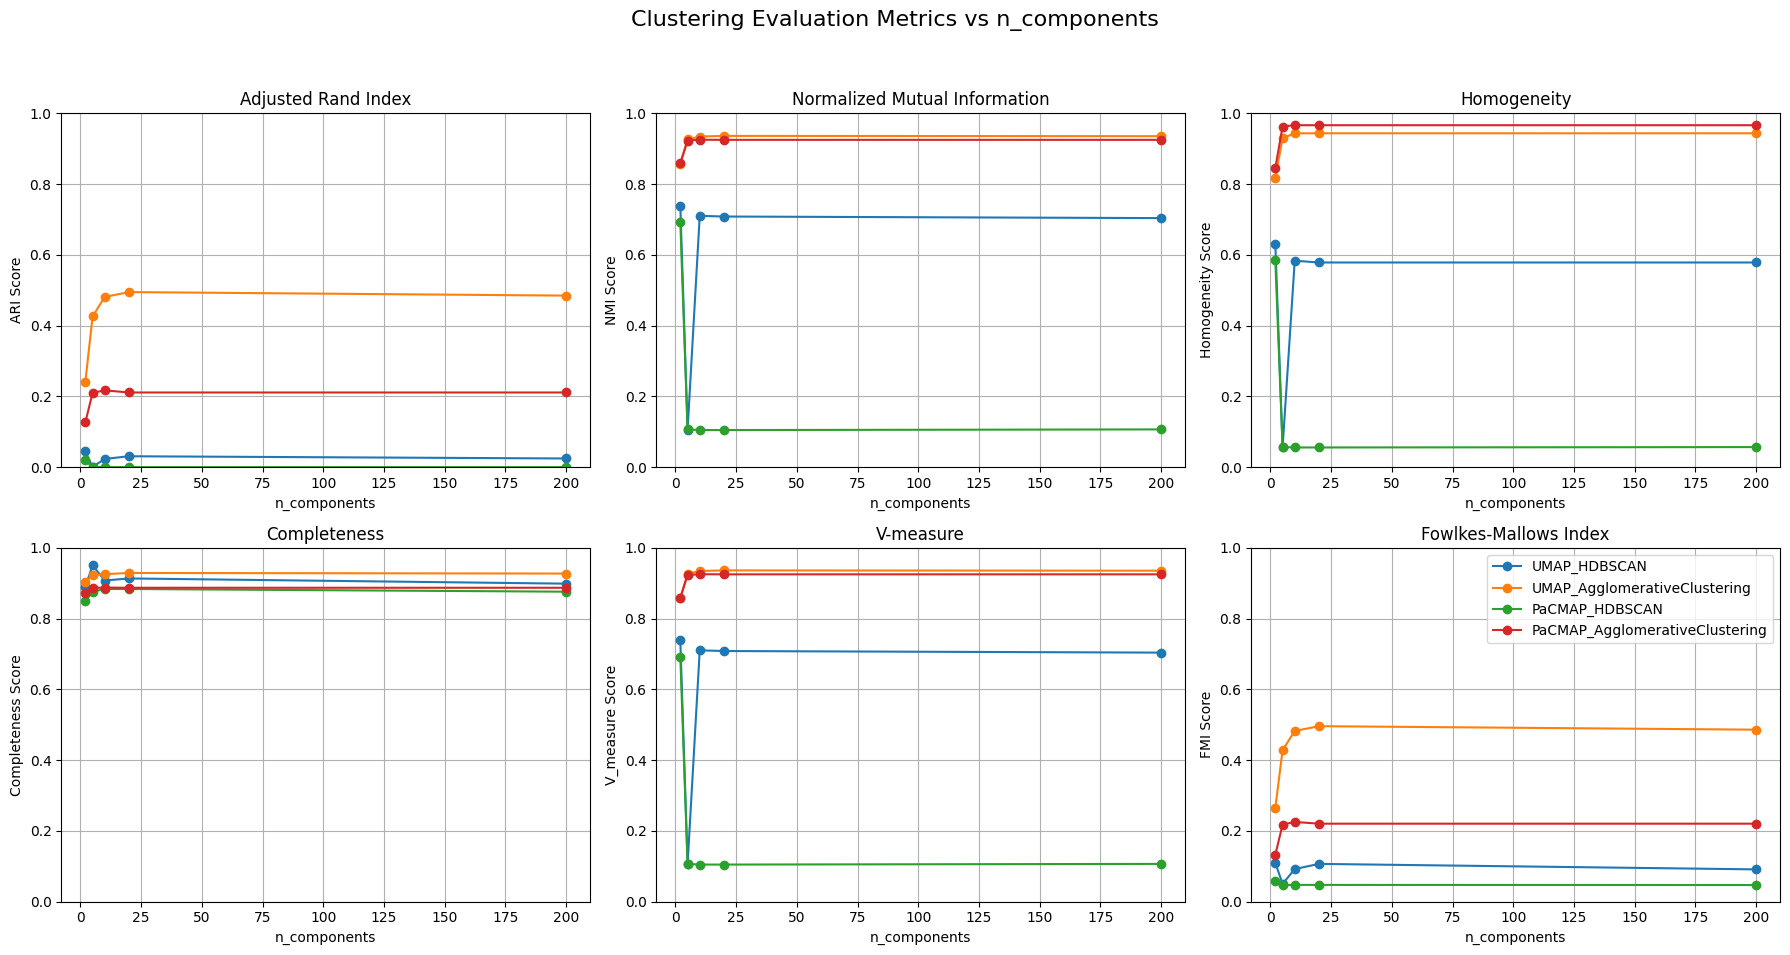

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import dimensionality reduction packages
import umap.umap_ as umap
import pacmap

# Import clustering algorithms
import hdbscan
from sklearn.cluster import AgglomerativeClustering

# Import clustering evaluation metrics
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             homogeneity_score, completeness_score, v_measure_score, 
                             fowlkes_mallows_score)

def compute_cluster_metrics(y_true, y_pred):
    """
    Compute common clustering evaluation metrics.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth cluster labels.
    y_pred : array-like
        Predicted cluster labels.
        
    Returns:
    --------
    dict : A dictionary containing:
           - ARI: Adjusted Rand Index
           - NMI: Normalized Mutual Information
           - Homogeneity
           - Completeness
           - V-measure
           - FMI: Fowlkes-Mallows Index
    """
    metrics = {
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred),
        "Homogeneity": homogeneity_score(y_true, y_pred),
        "Completeness": completeness_score(y_true, y_pred),
        "V_measure": v_measure_score(y_true, y_pred),
        "FMI": fowlkes_mallows_score(y_true, y_pred),
    }
    return metrics


n_components_list = [2, 5, 10, 20, 200]
dr_methods = ["UMAP", "PaCMAP"]
clustering_algos = ["HDBSCAN", "AgglomerativeClustering"]


results_dict = {}

embd = query_embeddings
embd = summary_embeddings
y_true = df["cluster_id"].values

for dr_method in dr_methods:
    for clust_algo in clustering_algos:
        config_key = f"{dr_method}_{clust_algo}"

        results_dict[config_key] = {
            "n_components": [],
            "ARI": [],
            "NMI": [],
            "Homogeneity": [],
            "Completeness": [],
            "V_measure": [],
            "FMI": [],
        }
        
        for n_comp in n_components_list:
           
            if dr_method == "UMAP":
                transformer = umap.UMAP(n_components=n_comp, random_state=42)
            elif dr_method == "PaCMAP":
                transformer = pacmap.PaCMAP(n_components=n_comp, random_state=42)
            else:
                raise ValueError("Unknown DR method!")
            
            X_dr = transformer.fit_transform(embd)
            
         
            if clust_algo == "HDBSCAN":
                clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
                clusterer.fit(X_dr)
                y_pred = clusterer.labels_
            elif clust_algo == "AgglomerativeClustering":
                clusterer = AgglomerativeClustering(n_clusters=None, 
                                                    distance_threshold=0.34, 
                                                    metric="euclidean")
                y_pred = clusterer.fit_predict(X_dr)
            else:
                raise ValueError("Unknown clustering algorithm!")
            
            
            metrics = compute_cluster_metrics(y_true, y_pred)
            
         
            results_dict[config_key]["n_components"].append(n_comp)
            results_dict[config_key]["ARI"].append(metrics["ARI"])
            results_dict[config_key]["NMI"].append(metrics["NMI"])
            results_dict[config_key]["Homogeneity"].append(metrics["Homogeneity"])
            results_dict[config_key]["Completeness"].append(metrics["Completeness"])
            results_dict[config_key]["V_measure"].append(metrics["V_measure"])
            results_dict[config_key]["FMI"].append(metrics["FMI"])
            
            print(f"Done {config_key} with n_components={n_comp}")


metrics_list = ["ARI", "NMI", "Homogeneity", "Completeness", "V_measure", "FMI"]
plot_names_map = {"ARI": "Adjusted Rand Index",
                  "NMI": "Normalized Mutual Information",
                  "Homogeneity": "Homogeneity",
                  "Completeness": "Completeness",
                  "V_measure": "V-measure",
                  "FMI": "Fowlkes-Mallows Index"
                  }


fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics_list):
    ax = axs[i]
    for config_key, result in results_dict.items():
        ax.plot(result["n_components"], result[metric], marker='o', label=config_key)
    
    ax.set_title(plot_names_map[metric])
    ax.set_xlabel("n_components")
    ax.set_ylabel(metric + " Score")
    ax.set_ylim(0, 1)
    ax.grid(True)
ax.legend()
    
plt.suptitle("Clustering Evaluation Metrics vs n_components", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [53]:
def print_cluster_summaries(df, clustering_method, cluster_label):
    """
    Prints the title and summary for all movies in a given cluster from a specified clustering method.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing movie remakes data, with both ground truth and clustering results.
    clustering_method : str
        The column name representing the clustering method (e.g., "hdbscan_umap_cluster_id").
    cluster_label : int or str
        The cluster label to filter on.
    """
    # Filter the DataFrame for rows in the specified cluster
    cluster_df = df[df[clustering_method] == cluster_label]
    
    if cluster_df.empty:
        print(f"No summaries found for cluster {cluster_label} using {clustering_method}.")
        return
    
    print(f"Cluster {cluster_label} using {clustering_method} has {len(cluster_df)} movies:\n")
    for idx, row in cluster_df.iterrows():
        print(f"Title: {row['title']} ({row['cluster_id']})")
        print(f"Summary: {row['summary']}")
        print("-" * 80)

# Example usage:
# This will print all titles and summaries for movies in cluster 20 according
# to the hdbscan_umap_cluster_id clustering.
print_cluster_summaries(clusterd_df, "hdbscan_umap_cluster_id", 80)

Cluster 80 using hdbscan_umap_cluster_id has 7 movies:

Title: Against_All_Odds_(film) (570350)
Summary: Professional football player Terry Brogan is released by his team, the Los Angeles Outlaws. Aging, injured and in need of money, he is contacted by an old acquaintance, the shady gambler and nightclub owner Jake Wise , who wants him to find Jake's girlfriend Jessie Wyler , daughter of the Outlaws' owner. Jake claims that Jessie assaulted him, stole money and fled. Terry is reluctant to take on the job, but needs the money and is reminded by Wise that Wise is capable of blackmailing him. Terry gets in touch with Jessie's mother , ostensibly to find out where Jessie can be found, but mainly to convince Mrs. Wyler and her business partner Ben Caxton to reinstate him on the team. Mrs. Wyler makes clear that she has no interest in his football career. She's willing to pay him more than Jake would if he will find Jessie for her, rather than for Jake. Beyond that, however, she has no use f

In [14]:
import torch
import math
def DIEM(source: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Source: https://arxiv.org/pdf/2407.08623

    Computes the DIEM distance between two tensors.
    DIEM: Dimension Insenstiive Embedding Metric

    Args:
        source (torch.Tensor): The source tensor of shape (N, D).
        target (torch.Tensor): The target tensor of shape (M, D).

    Returns:
        torch.Tensor: The DIEM distance between the source and target tensors of shape (N, M).

    """
    if source.size(1) != target.size(1):
        raise ValueError(
            "The source and target tensors must have the same dimension."
        )
    D = source.size(1)

    v_min = torch.min(torch.cat([source, target]))
    v_max = torch.max(torch.cat([source, target]))

    euclidean_dist = torch.cdist(source, target, p=2)
    expected_value = math.sqrt(D / 6) * (v_max - v_min)
    variance = torch.var(euclidean_dist)

    return (v_max - v_min) / variance * (euclidean_dist - expected_value)





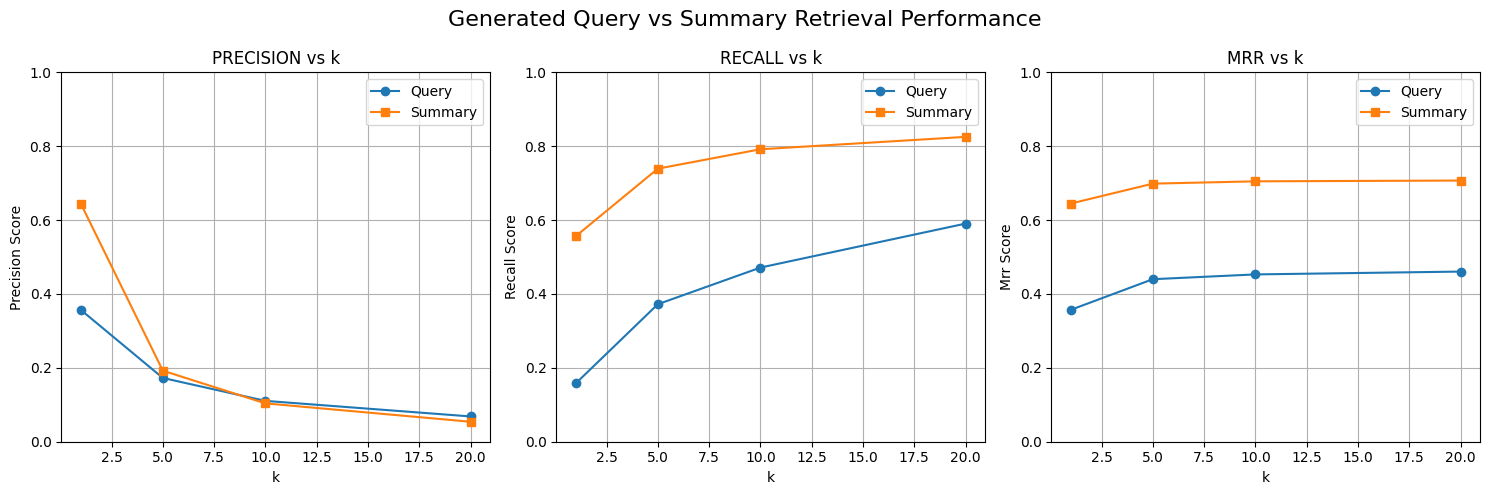

In [15]:
def evaluate_topk_retrieval(cluster_ids, embeddings, query_embeddings = None, k=10, metric='cosine'):
    """
    Evaluate top-k retrieval performance using cluster_ids as ground truth.

    Parameters:
    -----------
    embeddings : np.ndarray
        Matrix of embeddings with shape (n_samples, embedding_dim)
    cluster_ids : list or np.ndarray
        List of cluster IDs corresponding to each embedding
    k : int
        Number of top results to consider
    metric : str
        Distance metric to use ('cosine' or 'euclidean')

    Returns:
    --------
    dict : Dictionary containing evaluation metrics:
           - precision@k
           - recall@k
           - mrr (mean reciprocal rank)
    """
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

    n_samples = len(embeddings)
    if metric == 'cosine':
        metric_fn = cosine_similarity
    elif metric == 'euclidean':
        metric_fn = euclidean_distances
    else:
        raise ValueError("Unknown metric!")
    
    if query_embeddings is not None:
        sim_matrix = metric_fn(query_embeddings, embeddings)
    else:
        sim_matrix = metric_fn(embeddings, embeddings)
        np.fill_diagonal(sim_matrix, -np.inf)
    
 
    topk_indices = np.argsort(-sim_matrix, axis=1)[:, :k]
    
    precisions = []
    recalls = []
    mrr = []  
    
    for i in range(n_samples):
        query_cluster = cluster_ids[i]
        retrieved_clusters = [cluster_ids[idx] for idx in topk_indices[i]]
        
        if query_embeddings is not None:
            relevant_count = sum(1 for cid in cluster_ids if cid == query_cluster)
        else:
            relevant_count = sum(1 for cid in cluster_ids if cid == query_cluster) - 1

        relevant_retrieved = sum(1 for c in retrieved_clusters if c == query_cluster)
        precision = relevant_retrieved / k
        recall = relevant_retrieved / relevant_count if relevant_count > 0 else 0
        
        rr = 0
        for rank, c in enumerate(retrieved_clusters, start=1):
            if c == query_cluster:
                rr = 1 / rank
                break
            
        precisions.append(precision)
        recalls.append(recall)
        mrr.append(rr)
    
    return {
        f'precision@{k}': np.mean(precisions),
        f'recall@{k}': np.mean(recalls),
        'mrr': np.mean(mrr)
    }

cluster_ids = df['cluster_id'].tolist()

k_values = [1, 5, 10, 20]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Generated Query vs Summary Retrieval Performance', fontsize=16)
axs = axs.flatten()
metrics = ['precision', 'recall', 'mrr']

results_by_k_query = {k: evaluate_topk_retrieval(cluster_ids, summary_embeddings, query_embeddings=query_embeddings, k=k) for k in k_values}
results_by_k_no_query = {k: evaluate_topk_retrieval(cluster_ids, summary_embeddings, k=k) for k in k_values}


for i, metric in enumerate(metrics):

    ax1 = axs[i]
    if metric == 'mrr':
        values_query = [results_by_k_query[k]['mrr'] for k in k_values]
        values_no_query = [results_by_k_no_query[k]['mrr'] for k in k_values]
    else:
        values_query = [results_by_k_query[k][f'{metric}@{k}'] for k in k_values]
        values_no_query = [results_by_k_no_query[k][f'{metric}@{k}'] for k in k_values]
    
    ax1.plot(k_values, values_query, marker='o', label='Query')
    ax1.plot(k_values, values_no_query, marker='s', label='Summary')
    ax1.set_xlabel('k')
    ax1.set_ylabel(f'{metric.capitalize()} Score')
    ax1.set_title(f'{metric.upper()} vs k')
    ax1.set_ylim(0, 1)
    ax1.grid(True)
    ax1.legend()

plt.tight_layout()
plt.show()

    
        
        



In [16]:
from FlagEmbedding import BGEM3FlagModel
import numpy as np
import random
model = BGEM3FlagModel(model_name_or_path="BAAI/bge-m3")

def sample_random_clusters(df, max_samples, random_state=None):
    cluster_sizes = df.groupby('cluster_id').size()
    

    cluster_ids = cluster_sizes.index.tolist()
    if random_state is not None:
        random.seed(random_state)
    random.shuffle(cluster_ids)
    

    selected_clusters = []
    current_samples = 0
    
    for cluster_id in cluster_ids:
        cluster_size = cluster_sizes[cluster_id]
        if current_samples + cluster_size > max_samples:
     
            if current_samples == 0:
                selected_clusters.append(cluster_id)
            break
        
        selected_clusters.append(cluster_id)
        current_samples += cluster_size
    

    sampled_df = df[df['cluster_id'].isin(selected_clusters)].copy()
    
    print(f"Selected {len(selected_clusters)} clusters")
    print(f"Total samples: {len(sampled_df)}")
    print("\nCluster size statistics:")
    print(sampled_df.groupby('cluster_id').size().describe())
    
    return sampled_df


sampled_df = sample_random_clusters(df, max_samples=100, random_state=26)
sampled_df.groupby("cluster_id").size().sort_values(ascending=False)
len(sampled_df)

summaries = sampled_df["summary"].tolist()
sentence_pairs = []
n = len(summaries)
for i in range(n):  
    for j in range(i + 1, n):
        sentence_pairs.append((summaries[i], summaries[j]))

scores = model.compute_score(sentence_pairs=sentence_pairs, batch_size=4, max_query_length=2048, max_passage_length=4096)


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\Fergons\Desktop\narana\.venv\Lib\site-packages\FlagEmbedding\BGE_M3\modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  colbert_state_dict = torch.load(o

Selected 45 clusters
Total samples: 98

Cluster size statistics:
count    45.000000
mean      2.177778
std       0.441531
min       2.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       4.000000
dtype: float64


Compute Scores:   0%|          | 3/1189 [00:00<02:50,  6.97it/s]

default weights for dense, sparse, colbert are [1.0, 1.0, 1.0] 


Compute Scores: 100%|██████████| 1189/1189 [01:28<00:00, 13.44it/s]


Similarity matrix for 'colbert':
[[0.         0.72737718 0.52616882 ... 0.52836978 0.48600379 0.52070552]
 [0.72737718 0.         0.57639402 ... 0.54855978 0.50296247 0.5565387 ]
 [0.52616882 0.57639402 0.         ... 0.80202675 0.63087255 0.76665556]
 ...
 [0.52836978 0.54855978 0.80202675 ... 0.         0.64931589 0.81494069]
 [0.48600379 0.50296247 0.63087255 ... 0.64931589 0.         0.65221876]
 [0.52070552 0.5565387  0.76665556 ... 0.81494069 0.65221876 0.        ]]


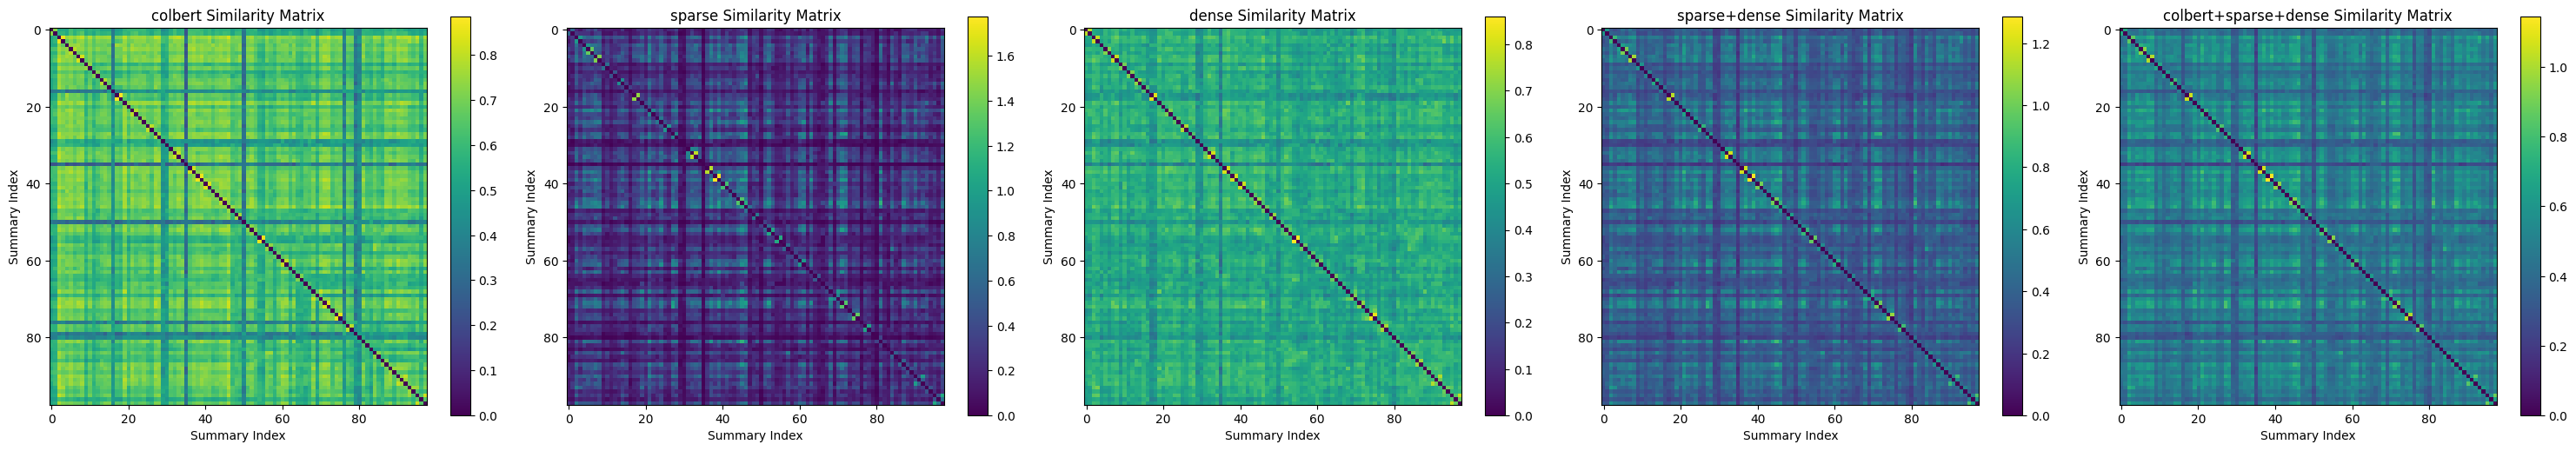

In [20]:
def create_similarity_matrix(scores_list, n):
    sim_matrix = np.zeros((n, n))
    
    idx = 0
    #  upper triangle (and mirror to lower triangle). 
    for i in range(n):
        for j in range(i + 1, n):
            sim_matrix[i, j] = scores_list[idx]
            sim_matrix[j, i] = scores_list[idx]
            idx += 1
    
    if idx != len(scores_list):
        raise ValueError("Mismatch between number of scores and expected number of pairs")
    
    return sim_matrix


summaries = sampled_df["summary"].tolist()
n = len(summaries)


similarity_matrices = {}
for key, score_list in scores.items():
    similarity_matrices[key] = create_similarity_matrix(score_list, n)


print("Similarity matrix for 'colbert':")
print(similarity_matrices['colbert'])



n_matrices = len(similarity_matrices)
fig, axes = plt.subplots(1, n_matrices, figsize=(6*n_matrices, 5))

if n_matrices == 1:
    axes = [axes] 


for ax, (key, matrix) in zip(axes, similarity_matrices.items()):
    im = ax.imshow(matrix, cmap='viridis')
    ax.set_title(f'{key} Similarity Matrix')
    plt.colorbar(im, ax=ax)
    ax.set_xlabel('Summary Index')
    ax.set_ylabel('Summary Index')

plt.tight_layout()
plt.show()




Metrics for colbert:

k=1:
  precision@1: 0.6224
  recall@1: 0.5187
  mrr: 0.6224

k=5:
  precision@5: 0.1551
  recall@5: 0.6378
  mrr: 0.6537

k=10:
  precision@10: 0.0888
  recall@10: 0.7092
  mrr: 0.6616

k=20:
  precision@20: 0.0490
  recall@20: 0.7738
  mrr: 0.6644

Metrics for sparse:

k=1:
  precision@1: 0.6837
  recall@1: 0.5714
  mrr: 0.6837

k=5:
  precision@5: 0.1776
  recall@5: 0.6939
  mrr: 0.7053

k=10:
  precision@10: 0.0969
  recall@10: 0.7602
  mrr: 0.7115

k=20:
  precision@20: 0.0520
  recall@20: 0.8265
  mrr: 0.7160

Metrics for dense:

k=1:
  precision@1: 0.7143
  recall@1: 0.6054
  mrr: 0.7143

k=5:
  precision@5: 0.1918
  recall@5: 0.7670
  mrr: 0.7532

k=10:
  precision@10: 0.1041
  recall@10: 0.8214
  mrr: 0.7591

k=20:
  precision@20: 0.0566
  recall@20: 0.8980
  mrr: 0.7631

Metrics for sparse+dense:

k=1:
  precision@1: 0.6939
  recall@1: 0.5816
  mrr: 0.6939

k=5:
  precision@5: 0.1898
  recall@5: 0.7500
  mrr: 0.7253

k=10:
  precision@10: 0.1051
  recall

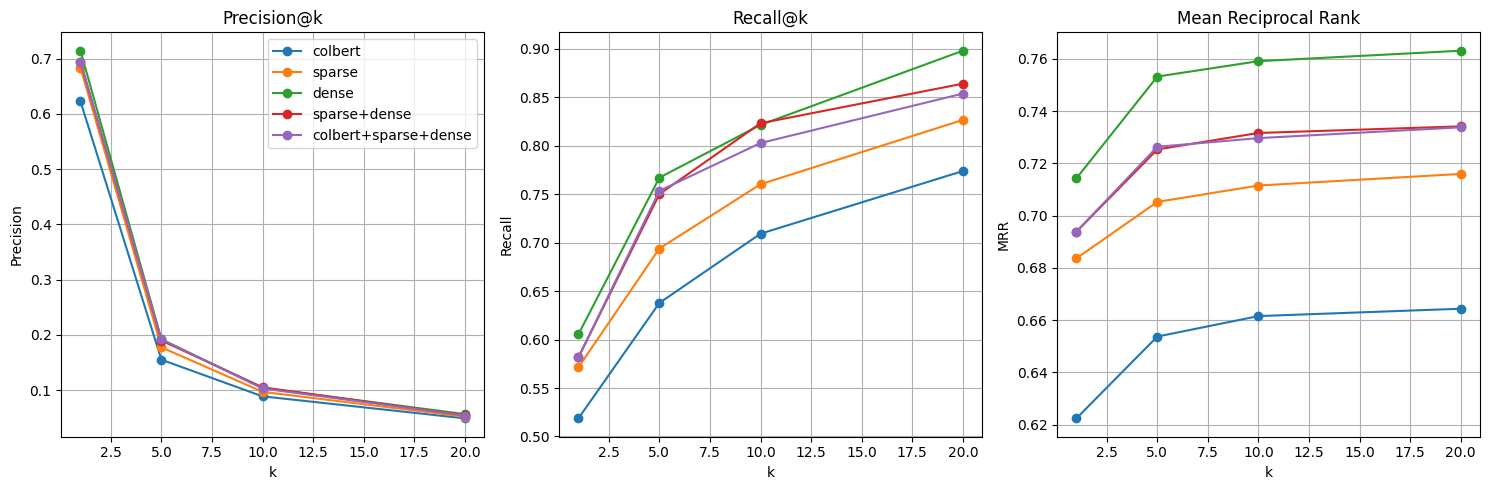

In [22]:
import numpy as np

def compute_retrieval_metrics(sim_matrix, cluster_ids, k=10):
    n_samples = sim_matrix.shape[0]
    
    np.fill_diagonal(sim_matrix, -np.inf)
    
    precisions = []
    recalls = []
    mrrs = []
    
    for i in range(n_samples):
        sorted_indices = np.argsort(-sim_matrix[i])
        topk_indices = sorted_indices[:k]
        target_cluster = cluster_ids[i]
        total_relevant = sum(1 for cid in cluster_ids if cid == target_cluster) - 1
        relevant_in_topk = sum(1 for j in topk_indices if cluster_ids[j] == target_cluster)
        precision = relevant_in_topk / k
        recall = relevant_in_topk / total_relevant if total_relevant > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)

        rr = 0
        for rank, j in enumerate(topk_indices, start=1):
            if cluster_ids[j] == target_cluster:
                rr = 1 / rank
                break
        mrrs.append(rr)
    
    return {f"precision@{k}": np.mean(precisions),
            f"recall@{k}": np.mean(recalls),
            "mrr": np.mean(mrrs)}

ks = [1, 5, 10, 20]

cluster_ids = sampled_df["cluster_id"].tolist()

# Create lists to store metrics for plotting
precision_values = {key: [] for key in similarity_matrices.keys()}
recall_values = {key: [] for key in similarity_matrices.keys()} 
mrr_values = {key: [] for key in similarity_matrices.keys()}

for key, sim_matrix in similarity_matrices.items():
    print(f"\nMetrics for {key}:")
    for k in ks:
        metrics = compute_retrieval_metrics(sim_matrix, cluster_ids, k=k)
        print(f"\nk={k}:")
        for metric_name, metric_val in metrics.items():
            print(f"  {metric_name}: {metric_val:.4f}")
            if 'precision' in metric_name:
                precision_values[key].append(metric_val)
            elif 'recall' in metric_name:
                recall_values[key].append(metric_val)
            elif metric_name == 'mrr':
                mrr_values[key].append(metric_val)

# Plot the metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

for key in similarity_matrices.keys():
    ax1.plot(ks, precision_values[key], marker='o', label=key)
    ax2.plot(ks, recall_values[key], marker='o', label=key)
    ax3.plot(ks, mrr_values[key], marker='o', label=key)

ax1.set_xlabel('k')
ax1.set_ylabel('Precision')
ax1.set_title('Precision@k')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('k')
ax2.set_ylabel('Recall')
ax2.set_title('Recall@k')

ax2.grid(True)

ax3.set_xlabel('k')
ax3.set_ylabel('MRR')
ax3.set_title('Mean Reciprocal Rank')
ax3.grid(True)

plt.tight_layout()
plt.show()